In [1]:
import pandas as pd
import numpy as np

In [5]:
data=pd.read_csv('tips (data for regression problem).csv')

In [6]:
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
X = data.drop("tip", axis=1)
y = data["tip"]

# Identify numeric and categorical columns
numeric_features = ["total_bill", "size"]
categorical_features = ["sex", "smoker", "day", "time"]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
X_train.shape

(195, 6)

In [9]:
X_test.shape

(49, 6)

In [10]:
# for evaluating the performance of all model we make a helper function
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2


In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Initialize models with pipelines
models = {
    "Linear Regression": Pipeline([("preprocessor", preprocessor), ("regressor", LinearRegression())]),
    "Ridge Regression": Pipeline([("preprocessor", preprocessor), ("regressor", Ridge(alpha=1.0))]),
    "Lasso Regression": Pipeline([("preprocessor", preprocessor), ("regressor", Lasso(alpha=0.1))]),
    "Decision Tree": Pipeline([("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor(random_state=42))]),
    "Random Forest": Pipeline([("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state=42))]),
    "Support Vector Regression (SVR)": Pipeline([("preprocessor", preprocessor), ("regressor", SVR(kernel='rbf', C=1.0))]),
    "K-Nearest Neighbors": Pipeline([("preprocessor", preprocessor), ("regressor", KNeighborsRegressor(n_neighbors=5))])
}


In [12]:
#evaluation of each model
# Evaluate models and store results
results = {}
for model_name, model_pipeline in models.items():
    mae, mse, r2 = evaluate_model(model_pipeline, X_train, X_test, y_train, y_test)
    results[model_name] = {"MAE": mae, "MSE": mse, "R^2": r2}
    print(f"{model_name}: MAE={mae:.2f}, MSE={mse:.2f}, R^2={r2:.2f}")

# Display the results in a DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:\n", results_df)


Linear Regression: MAE=0.67, MSE=0.70, R^2=0.44
Ridge Regression: MAE=0.67, MSE=0.70, R^2=0.44
Lasso Regression: MAE=0.65, MSE=0.61, R^2=0.51
Decision Tree: MAE=0.83, MSE=1.26, R^2=-0.00
Random Forest: MAE=0.75, MSE=0.92, R^2=0.27
Support Vector Regression (SVR): MAE=0.65, MSE=0.71, R^2=0.43
K-Nearest Neighbors: MAE=0.71, MSE=0.80, R^2=0.36

Model Evaluation Results:
                                       MAE       MSE       R^2
Linear Regression                0.667133  0.703357  0.437302
Ridge Regression                 0.666859  0.700651  0.439466
Lasso Regression                 0.654809  0.612210  0.510221
Decision Tree                    0.829592  1.255194 -0.004178
Random Forest                    0.752882  0.918199  0.265424
Support Vector Regression (SVR)  0.646897  0.709525  0.432367
K-Nearest Neighbors              0.708653  0.804866  0.356092


In [13]:
# Only linear models have feature coefficients
for model_name in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
    # Use the pipeline here instead of just the regressor
    model_pipeline = models[model_name] 
    
    # Fit the pipeline (which includes preprocessing)
    model_pipeline.fit(X_train, y_train)  
    
    # Get the regressor from the pipeline
    model = model_pipeline.named_steps["regressor"]
    
    feature_importance = np.concatenate((model.coef_,), axis=None)  # Combine coefficients
    feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out())
    print(f"\nFeature Importance for {model_name}:\n", dict(zip(feature_names, feature_importance)))


Feature Importance for Linear Regression:
 {'total_bill': 0.8284320874441262, 'size': 0.219073150662623, 'sex_Male': 0.028819282882043284, 'smoker_Yes': -0.19235325176307053, 'day_Sat': -0.18578529673367092, 'day_Sun': -0.0507933877300554, 'day_Thur': -0.17972097719353936, 'time_Lunch': 0.09495716090944495}

Feature Importance for Ridge Regression:
 {'total_bill': 0.8212412310240527, 'size': 0.2213872105148993, 'sex_Male': 0.028314617046455035, 'smoker_Yes': -0.1820356928873803, 'day_Sat': -0.16701791795803267, 'day_Sun': -0.032155502611160715, 'day_Thur': -0.14037347903199282, 'time_Lunch': 0.07376656019685808}

Feature Importance for Lasso Regression:
 {'total_bill': 0.731173336581101, 'size': 0.18478848276383622, 'sex_Male': 0.0, 'smoker_Yes': -0.0, 'day_Sat': -0.0, 'day_Sun': 0.0, 'day_Thur': -0.0, 'time_Lunch': -0.0}


In [16]:
import statsmodels.api as sm

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
# Set plot style
sns.set(style="whitegrid")


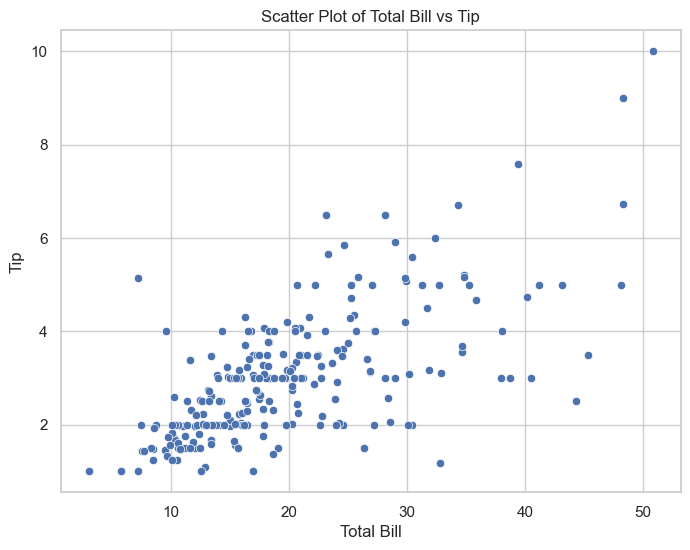

In [18]:
#scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="total_bill", y="tip", data=data)
plt.title("Scatter Plot of Total Bill vs Tip")
plt.xlabel("Total Bill")
plt.ylabel("Tip")
plt.show()


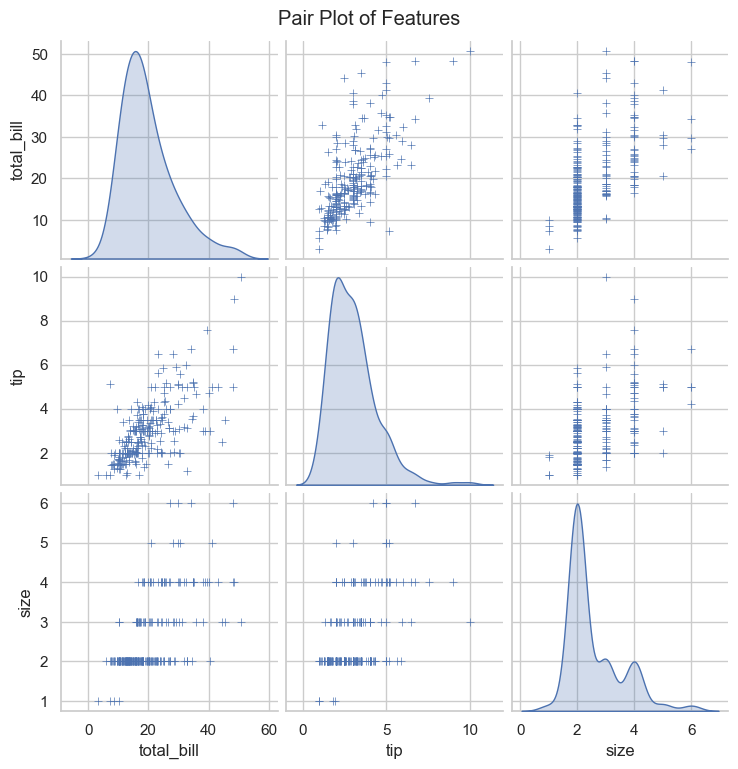

In [19]:
#pair plot for multiple features
sns.pairplot(data, diag_kind="kde", markers="+")
plt.suptitle("Pair Plot of Features", y=1.02)
plt.show()


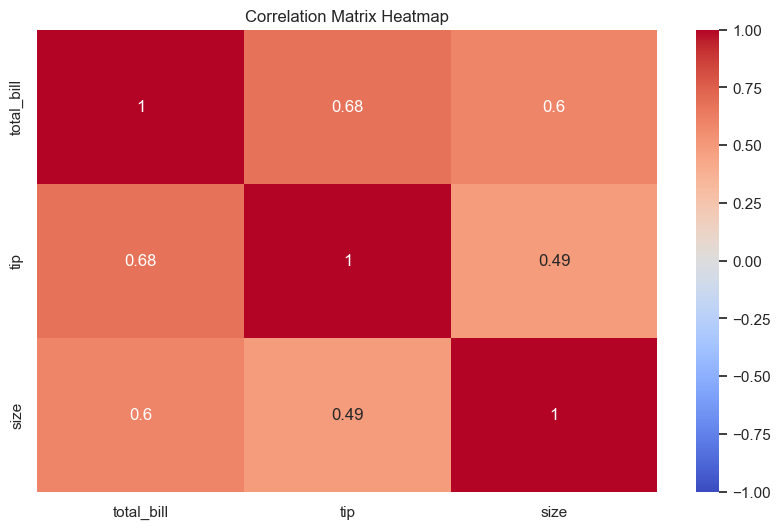

In [20]:
#correlation matrix(heatmap)
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=np.number)  
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [21]:
# stastical test for linearity (Rainbow test)
# Add a constant for the intercept
X = sm.add_constant(data["total_bill"])
y = data["tip"]

# Fit a simple OLS model
model = OLS(y, X).fit()
rainbow_stat, rainbow_p_val = linear_rainbow(model)

print(f"Rainbow Test Statistic: {rainbow_stat:.4f}")
print(f"Rainbow Test p-value: {rainbow_p_val:.4f}")
# If p-value < 0.05, we may reject linearity


Rainbow Test Statistic: 1.2291
Rainbow Test p-value: 0.1291


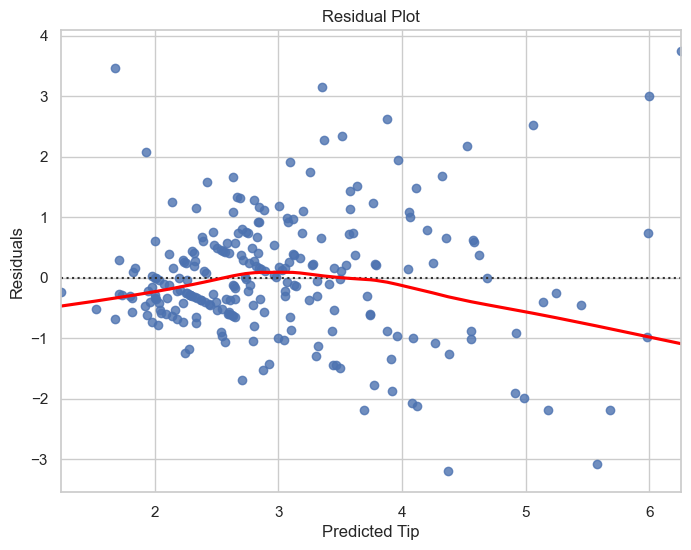

In [22]:
# Residuals test
predicted_values = model.predict(X)
residuals = y - predicted_values

plt.figure(figsize=(8, 6))
sns.residplot(x=predicted_values, y=residuals, lowess=True, line_kws={"color": "red"})
plt.title("Residual Plot")
plt.xlabel("Predicted Tip")
plt.ylabel("Residuals")
plt.show()


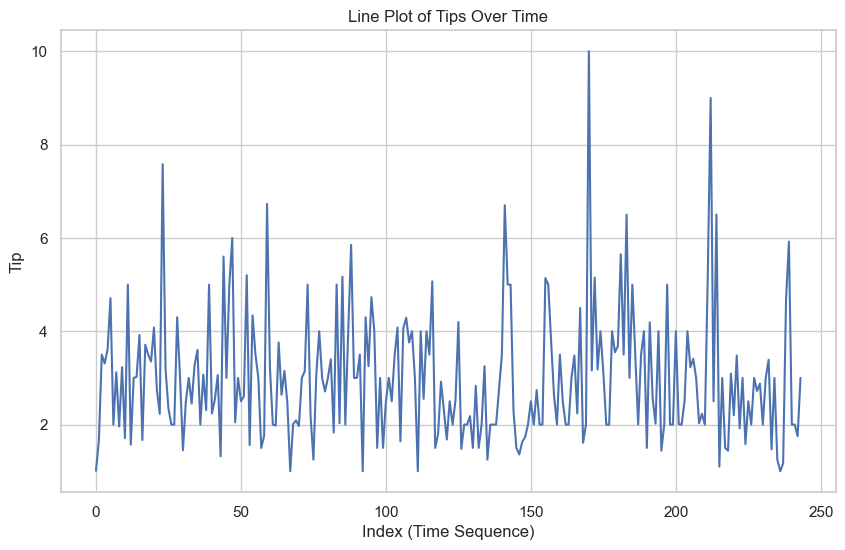

In [23]:
# line plot (for time series data)
if "time" in data.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(data)), y="tip", data=data)
    plt.title("Line Plot of Tips Over Time")
    plt.xlabel("Index (Time Sequence)")
    plt.ylabel("Tip")
    plt.show()
else:
    print("No time-series data in the dataset for line plot analysis.")
